In [1]:
import os
import glob
import tables
import argparse
import numpy as np
import pandas as pd
from time import time
from tables import *
from pathlib import Path
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy.signal import find_peaks
from tables.description import Float32Col, Float64Col

In [2]:
import tables
import os

filename = '/home/tirocinio/Codice/tirocinio/Dati/DL0/acquisizione_2023_01_27/rpg0/dl0/wf_runId_00293_configId_00000_2023-01-27T14_32_51.090204.h5'

class Reader:
    def get_data_list(self,filename,startIndex=0,endIndex=-1):
        '''get data from h5 file starting by startIndex and ending at endIndex
        '''
        data_list = []
        with tables.open_file(filename,mode='r') as h5file:
            group = h5file.get_node('/waveforms')
            if endIndex == -1:
                endIndex = group._g_getnchildren()
            for i,data in enumerate(group):
                if i >= startIndex:
                    arr = data[:,-1]
                    data_list.append(arr)
                if i>=endIndex-1:
                    break
            return data_list
        
def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"La directory '{directory_path}' è stata creata.")

reader = Reader()
data = reader.get_data_list(filename,10,15)

In [3]:
print(len(data))

5


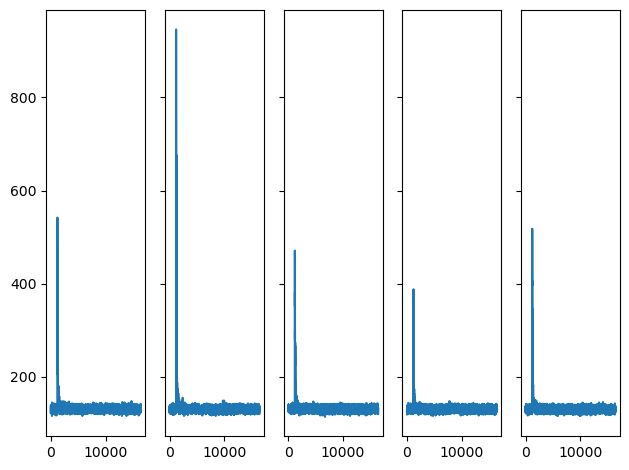

In [4]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 5, sharey=True, tight_layout=True)
for i in range(5):
    #print(len(data[i]))
    axs[i].plot(data[i])

/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:59: RuntimeWarning: overflow encountered in exp
  Q_k = np.exp(-a*T_k)/(1-np.exp(-a*T_k))
/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:59: RuntimeWarning: invalid value encountered in divide
  Q_k = np.exp(-a*T_k)/(1-np.exp(-a*T_k))


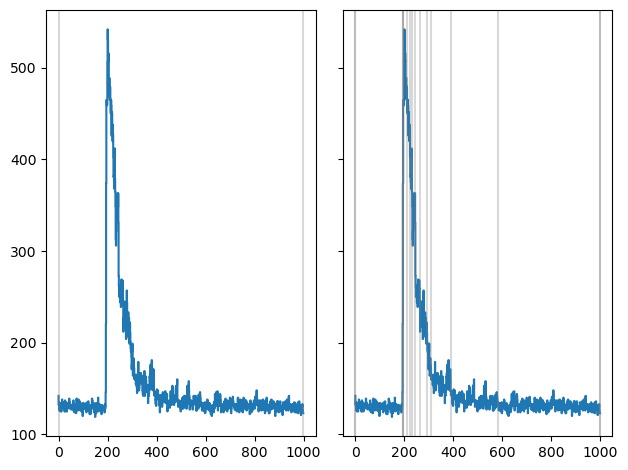

In [5]:
from astropy.stats import Events, bayesian_blocks
from bb_exponential import ExponentialBlocks_Events
t=range(1000)
x=data[0][1000:2000]
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].step(t, x)
axs[1].step(t, x)
xcoords = bayesian_blocks(t,x,fitness=ExponentialBlocks_Events)
for xc in xcoords:
    axs[0].axvline(x=xc, color='grey', alpha=0.3)
xcoords = bayesian_blocks(t,x,fitness='events')
for xc in xcoords:
    axs[1].axvline(x=xc, color='grey', alpha=0.3)
plt.show()

[ 0.   0.5 14. ]
{'a': nan, 'gamma': nan}
{'a': 0.6663024624896873, 'gamma': 21834.774392607025}


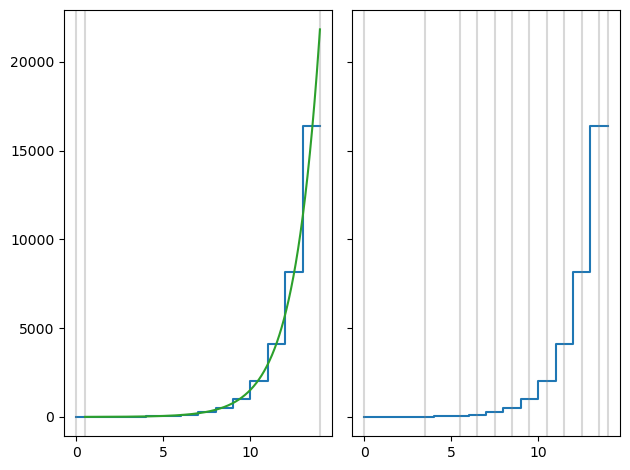

In [7]:
t=np.arange(0,15)
x=np.floor(np.power(2,t))
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].step(t, x)
axs[1].step(t, x)
xcoords = bayesian_blocks(t,x,fitness=ExponentialBlocks_Events)
print(xcoords)
for xc in xcoords:
    axs[0].axvline(x=xc, color='grey', alpha=0.3)
fitn = ExponentialBlocks_Events()
for i in range(len(xcoords)-1):
    edge_l = xcoords[i]
    edge_r = xcoords[i+1]
    params = fitn.get_parameters(edge_l,edge_r,t,x)
    print(params)
    plot_t = np.linspace(edge_l,edge_r,1000)
    plot_x = params['gamma'] * np.exp(params['a']*(plot_t - edge_r))
    axs[0].plot(plot_t,plot_x)
xcoords = bayesian_blocks(t,x,fitness='events')
for xc in xcoords:
    axs[1].axvline(x=xc, color='grey', alpha=0.3)